<a href="https://colab.research.google.com/github/mariapaoladicrosta/ADAML_MicrosoftStock/blob/main/MFSTStockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Loading

In [29]:
# Load data
data = pd.read_csv('MSFT_2006-01-01_to_2018-01-01.csv')

# Data summary and visualization
print("Dataset Head:\n", data.head())
print("Dataset Shape:\n",data.shape)

Dataset Head:
          Date   Open   High    Low  Close     Volume  Name
0  2006-01-03  26.25  27.00  26.10  26.84   79974418  MSFT
1  2006-01-04  26.77  27.08  26.77  26.97   57975661  MSFT
2  2006-01-05  26.96  27.13  26.91  26.99   48247610  MSFT
3  2006-01-06  26.89  27.00  26.49  26.91  100969092  MSFT
4  2006-01-09  26.93  27.07  26.76  26.86   55627836  MSFT
Dataset Shape:
 (3019, 7)


# Data Exploration

In [30]:
# Remove last column (constant value)
data = data.iloc[:, :-1]

# Check for missing values
missing = data.isnull().any(axis=1)
print("Rows with missing values:\n", data[missing])


Rows with missing values:
 Empty DataFrame
Columns: [Date, Open, High, Low, Close, Volume]
Index: []


In [31]:
# Display date range
print("Date Range:", data['Date'].min(), "to", data['Date'].max())

Date Range: 2006-01-03 to 2017-12-29


In [32]:
# Date processing for trading days per year
data['Date'] = pd.to_datetime(data['Date'], format='mixed')

years = data['Date'].dt.year
unique_years = years.unique()
date_counts = [sum(years == year) for year in unique_years]

# Display yearly count table
yearly_counts = pd.DataFrame({'Year': unique_years, 'Count': date_counts})
print(yearly_counts)

    Year  Count
0   2006    251
1   2007    251
2   2008    253
3   2009    252
4   2010    251
5   2011    252
6   2012    250
7   2013    252
8   2014    252
9   2015    252
10  2016    252
11  2017    251


# Missing weekdays

In [33]:
# Define the complete date range
full_date_range = pd.date_range(start='2006-01-03', end='2017-12-29', freq='D')  # All days in the range

# Identify missing dates
missing_dates = full_date_range.difference(data['Date'])

# Exclude Saturdays (5) and Sundays (6)
missing_dates_weekdays = [date for date in missing_dates if date.weekday() < 5]

# Convert to DataFrame for storage or further analysis
missing_dates_df = pd.DataFrame({'MissingDate': missing_dates_weekdays})

# Print results
print("All missing dates (excluding Saturdays and Sundays):")
print(missing_dates_df)

All missing dates (excluding Saturdays and Sundays):
    MissingDate
0    2006-01-16
1    2006-02-20
2    2006-04-14
3    2006-05-29
4    2006-07-04
..          ...
105  2017-05-29
106  2017-07-04
107  2017-09-04
108  2017-11-23
109  2017-12-25

[110 rows x 1 columns]


Missing Weekdays Imputation

In [34]:
# Create a copy of the data for imputation
original_data = data.copy()

# Loop through each missing date
for date in missing_dates_df['MissingDate']:
    # Find the previous and following dates
    previous_date = data[data['Date'] < date]['Date'].max()
    following_date = data[data['Date'] > date]['Date'].min()

    # Calculate the mean for all columns except 'Date'
    new_row = {'Date': date}
    for col in data.columns:
        if col != 'Date':
            previous_value = data.loc[data['Date'] == previous_date, col].values[0]
            following_value = data.loc[data['Date'] == following_date, col].values[0]
            new_row[col] = (previous_value + following_value) / 2

    # Append the new row
    data = pd.concat([data, pd.DataFrame([new_row])], ignore_index=True)

# Sort by date to ensure chronological order
data = data.sort_values(by='Date').reset_index(drop=True)

# Print the imputed dataset
print(data)

           Date    Open   High     Low   Close       Volume
0    2006-01-03  26.250  27.00  26.100  26.840   79974418.0
1    2006-01-04  26.770  27.08  26.770  26.970   57975661.0
2    2006-01-05  26.960  27.13  26.910  26.990   48247610.0
3    2006-01-06  26.890  27.00  26.490  26.910  100969092.0
4    2006-01-09  26.930  27.07  26.760  26.860   55627836.0
...         ...     ...    ...     ...     ...          ...
3124 2017-12-25  85.355  85.58  84.975  85.455   12018539.0
3125 2017-12-26  85.310  85.53  85.030  85.400    9891237.0
3126 2017-12-27  85.650  85.98  85.220  85.710   14678025.0
3127 2017-12-28  85.900  85.93  85.550  85.720   10594344.0
3128 2017-12-29  85.630  86.05  85.500  85.540   18717406.0

[3129 rows x 6 columns]


In [35]:
pip install pandas_market_calendars

In [36]:

import pandas_market_calendars as mcal
nyse = mcal.get_calendar('NYSE')

# Define the date range based on your specified range
start_date = '2006-01-03'
end_date = '2017-12-29'

# Get the trading schedule for the given date range
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
trading_days = schedule.index

# Check if trading days match data['Date']
missing_in_data = set(trading_days) - set(data['Date'])

# Print results
if not missing_in_data:
    print("All trading days are with data['Date'].")
else:
    print(f"Trading days missing in data['Date']: {sorted(missing_in_data)}")

All trading days are with data['Date'].


# Understand and Visualize the data

In [37]:
# Summary statistics
print(data.describe())

                                Date         Open         High         Low  \
count                           3129  3129.000000  3129.000000  3129.00000   
mean   2012-01-01 04:47:37.909875200    36.488142    36.817755    36.16631   
min              2006-01-03 00:00:00    15.200000    15.620000    14.87000   
25%              2009-01-01 00:00:00    26.800000    27.060000    26.56000   
50%              2012-01-02 00:00:00    29.990000    30.230000    29.78000   
75%              2014-12-31 00:00:00    44.480000    44.900000    44.06000   
max              2017-12-29 00:00:00    87.120000    87.500000    86.23000   
std                              NaN    14.673151    14.731234    14.60890   

             Close        Volume  
count  3129.000000  3.129000e+03  
mean     36.505228  5.125337e+07  
min      15.150000  7.425603e+06  
25%      26.840000  3.117109e+07  
50%      30.000000  4.599472e+07  
75%      44.395000  6.295082e+07  
max      86.850000  5.910786e+08  
std      14.68293

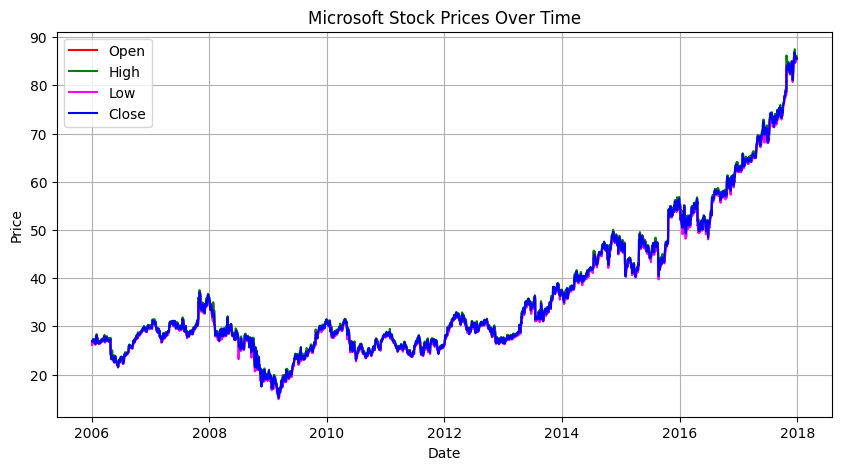

In [38]:
# Data Visualization - Time Series Analysis
plt.figure(figsize=(10, 5))
plt.plot(data['Date'], data['Open'], label='Open', color='red')
plt.plot(data['Date'], data['High'], label='High', color='green')
plt.plot(data['Date'], data['Low'], label='Low', color='magenta')
plt.plot(data['Date'], data['Close'], label='Close', color='blue')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Microsoft Stock Prices Over Time')
plt.legend()
plt.grid(True)
plt.show()

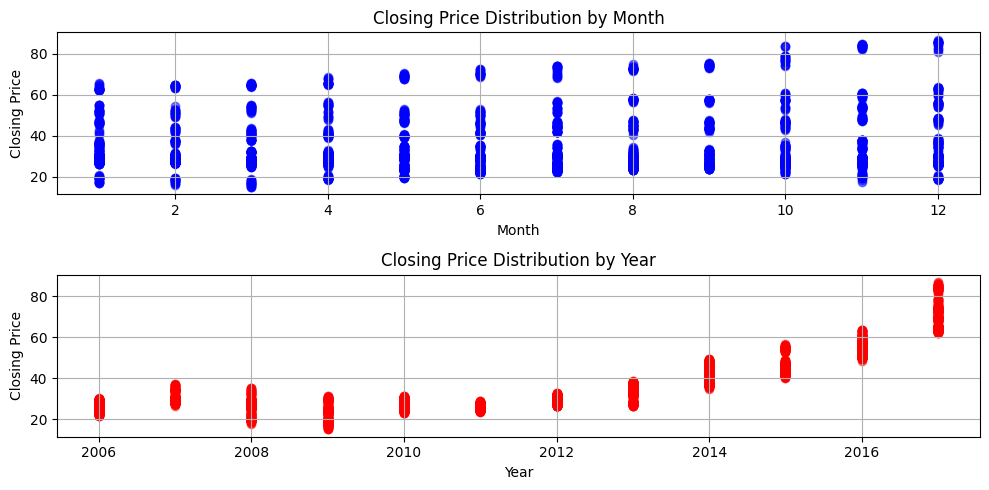

In [39]:
# Closing Price Distribution over Months and Years
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.scatter(data['Date'].dt.month, data['Close'], color='b', alpha=0.5)
plt.title('Closing Price Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Closing Price')
plt.grid(True)


plt.subplot(2, 1, 2)
plt.scatter(data['Date'].dt.year, data['Close'], color='r', alpha=0.5)
plt.title('Closing Price Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# Correlation between Volume and Close Price
correlation_coefficient = data['Close'].corr(data['Volume'])
print(f'The correlation between Volume and Close Price is: {correlation_coefficient:.4f}')


The correlation between Volume and Close Price is: -0.4854


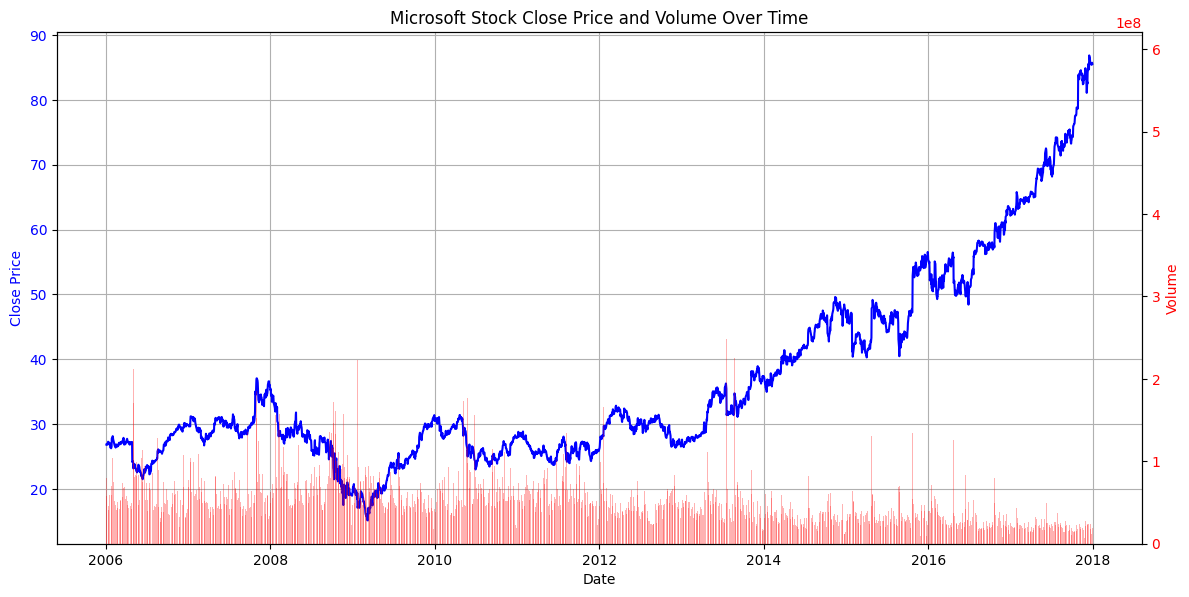

In [41]:
# Dual-axis plot for Close Price vs. Volume
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(data['Date'], data['Close'], 'b-', linewidth=1.5, label='Close Price')
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.bar(data['Date'], data['Volume'], alpha=0.3, color='r', width=1.5)
ax2.set_ylabel('Volume', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Microsoft Stock Close Price and Volume Over Time')
plt.show()

# Data Decomposition







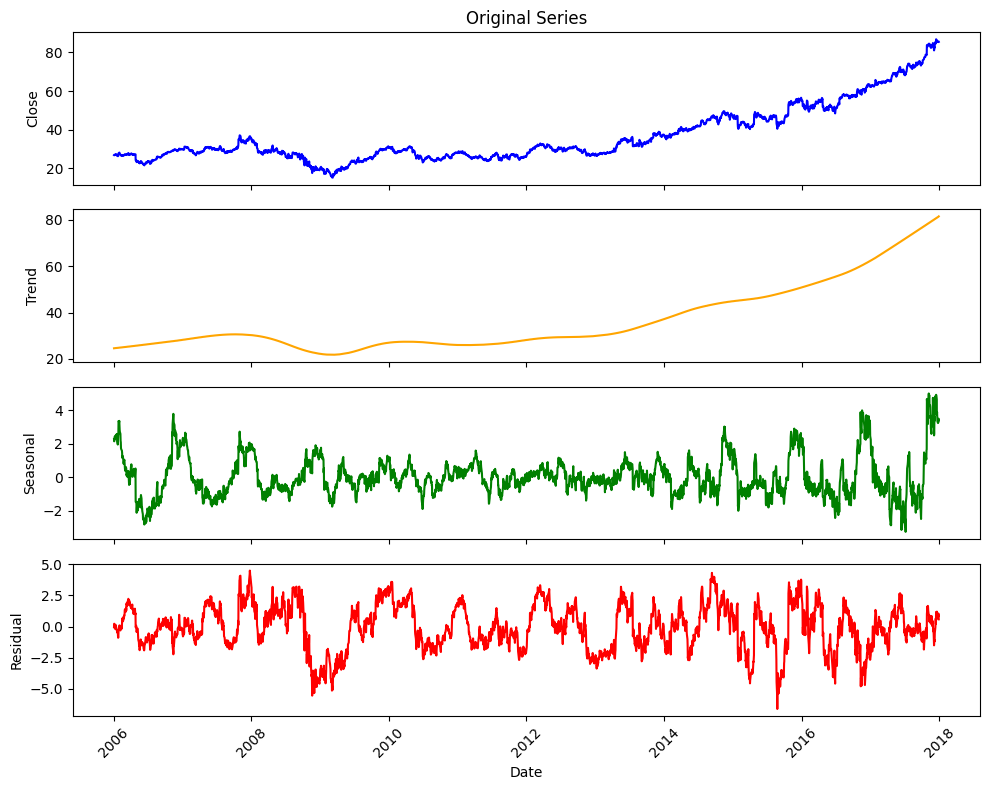

In [42]:
from statsmodels.tsa.seasonal import STL

# Perform seasonal decomposition using STL (Seasonal-Trend decomposition using LOESS)
stl = STL(data['Close'], period=252)
result = stl.fit()
trend = result.trend
seasonal = result.seasonal
residual = result.resid

fig, ax = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original series
ax[0].plot(data['Date'], data['Close'], color='blue')
ax[0].set_ylabel('Close')
ax[0].set_title('Original Series')

# Trend component
ax[1].plot(data['Date'], trend, color='orange')
ax[1].set_ylabel('Trend')

# Seasonal component
ax[2].plot(data['Date'], seasonal, color='green')
ax[2].set_ylabel('Seasonal')

# Residuals
ax[3].plot(data['Date'], residual, color='red')
ax[3].set_ylabel('Residual')

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Yearly, Monthly and Weekly Seasonality

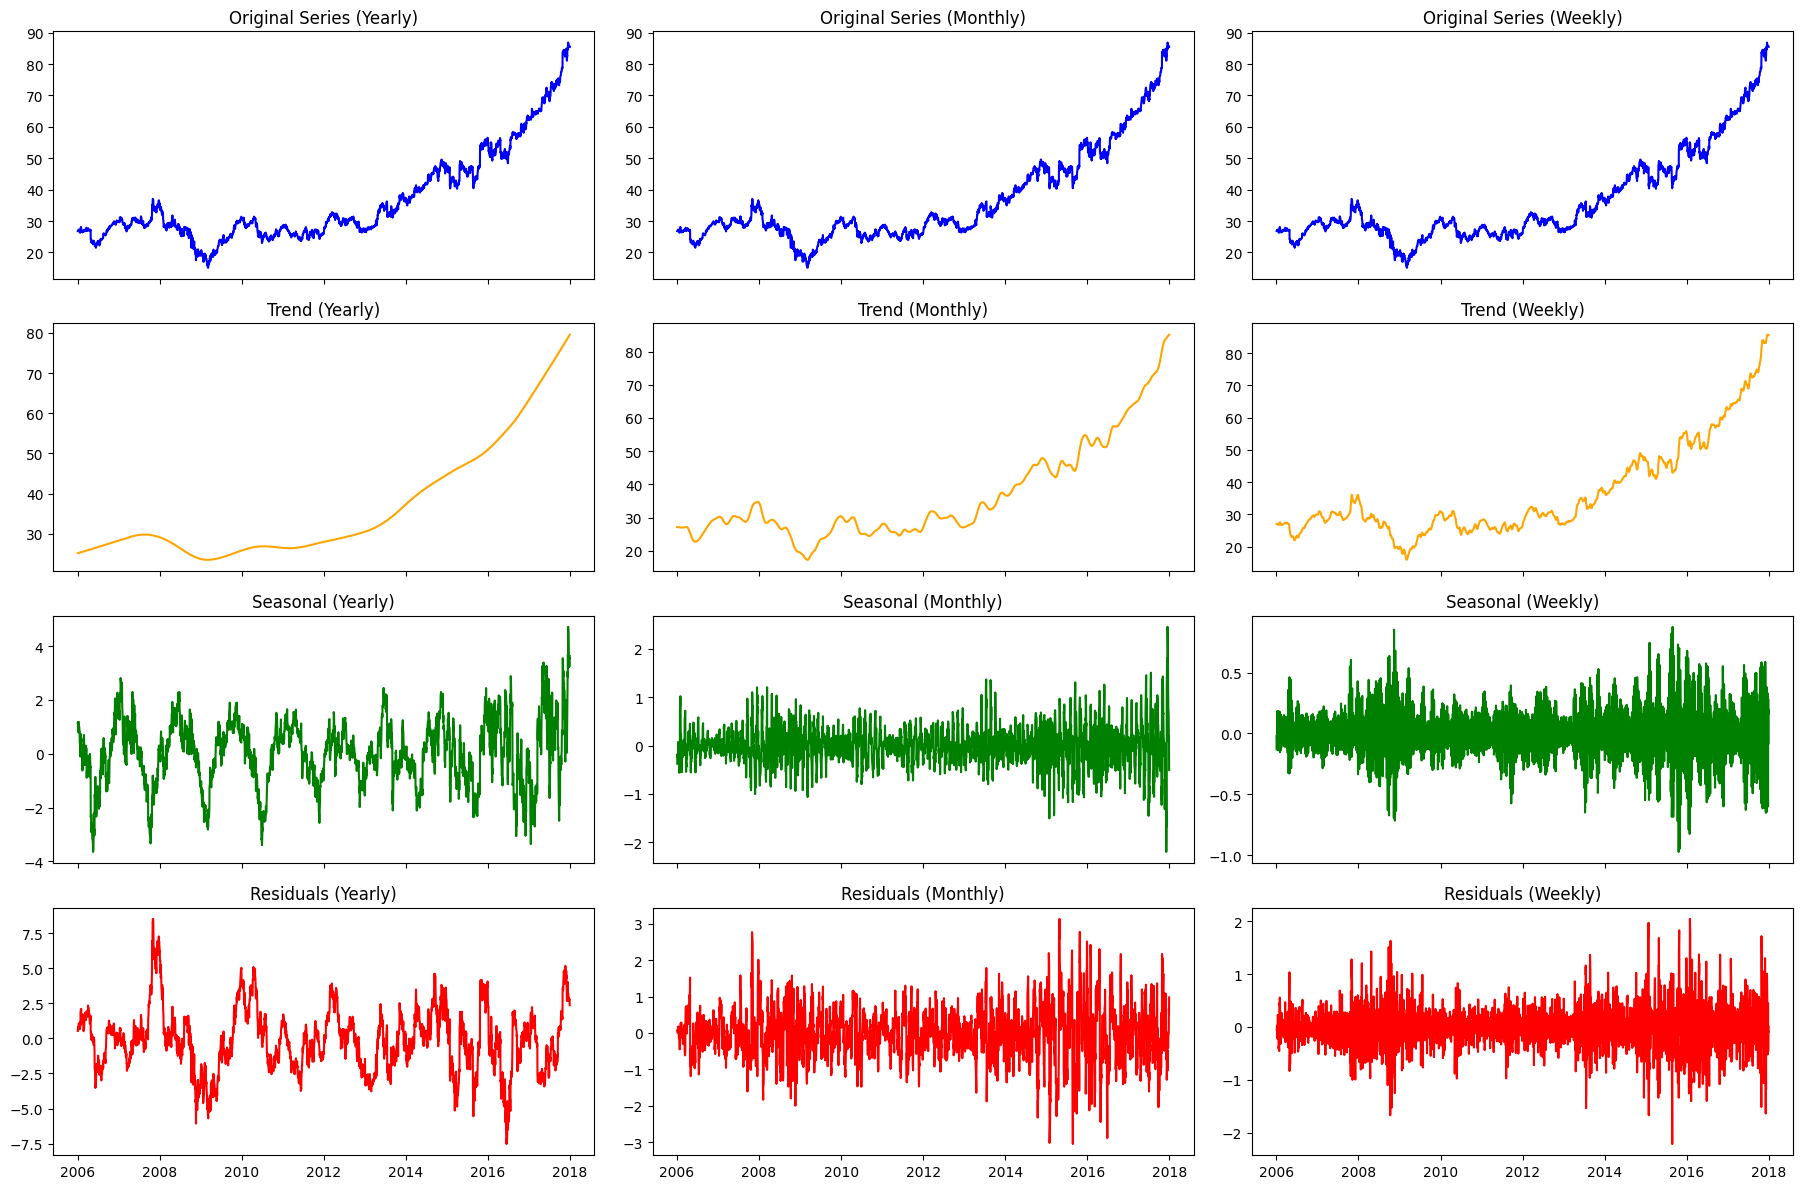

In [43]:
# Yearly Seasonality (252 trading days for stock market data)
stl_yearly = STL(data['Close'], period=365)
result_yearly = stl_yearly.fit()

# Monthly Seasonality (approx. 30 days)
stl_monthly = STL(data['Close'], period=30)
result_monthly = stl_monthly.fit()

# Weekly Seasonality (7 days)
stl_weekly = STL(data['Close'], period=7)
result_weekly = stl_weekly.fit()

# Plotting the decompositions for yearly, monthly, and weekly seasonal components
fig, axes = plt.subplots(4, 3, figsize=(18, 12), sharex=True)

# Yearly decomposition
axes[0, 0].plot(data['Date'], data['Close'], color='blue')
axes[0, 0].set_title('Original Series (Yearly)')

axes[1, 0].plot(data['Date'], result_yearly.trend, color='orange')
axes[1, 0].set_title('Trend (Yearly)')

axes[2, 0].plot(data['Date'], result_yearly.seasonal, color='green')
axes[2, 0].set_title('Seasonal (Yearly)')

axes[3, 0].plot(data['Date'], result_yearly.resid, color='red')
axes[3, 0].set_title('Residuals (Yearly)')

# Monthly decomposition
axes[0, 1].plot(data['Date'], data['Close'], color='blue')
axes[0, 1].set_title('Original Series (Monthly)')

axes[1, 1].plot(data['Date'], result_monthly.trend, color='orange')
axes[1, 1].set_title('Trend (Monthly)')

axes[2, 1].plot(data['Date'], result_monthly.seasonal, color='green')
axes[2, 1].set_title('Seasonal (Monthly)')

axes[3, 1].plot(data['Date'], result_monthly.resid, color='red')
axes[3, 1].set_title('Residuals (Monthly)')

# Weekly decomposition
axes[0, 2].plot(data['Date'], data['Close'], color='blue')
axes[0, 2].set_title('Original Series (Weekly)')

axes[1, 2].plot(data['Date'], result_weekly.trend, color='orange')
axes[1, 2].set_title('Trend (Weekly)')

axes[2, 2].plot(data['Date'], result_weekly.seasonal, color='green')
axes[2, 2].set_title('Seasonal (Weekly)')

axes[3, 2].plot(data['Date'], result_weekly.resid, color='red')
axes[3, 2].set_title('Residuals (Weekly)')

plt.tight_layout()
plt.show()

# Autocorrelation of Closing Price (target variable)

<Figure size 1000x500 with 0 Axes>

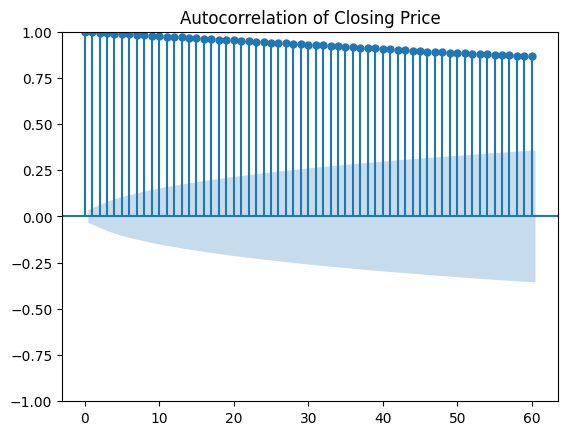

In [44]:
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation of Close Price
plt.figure(figsize=(10, 5))
plot_acf(data['Close'], lags=60)
plt.title('Autocorrelation of Closing Price')
plt.show()

# Outliers Detection

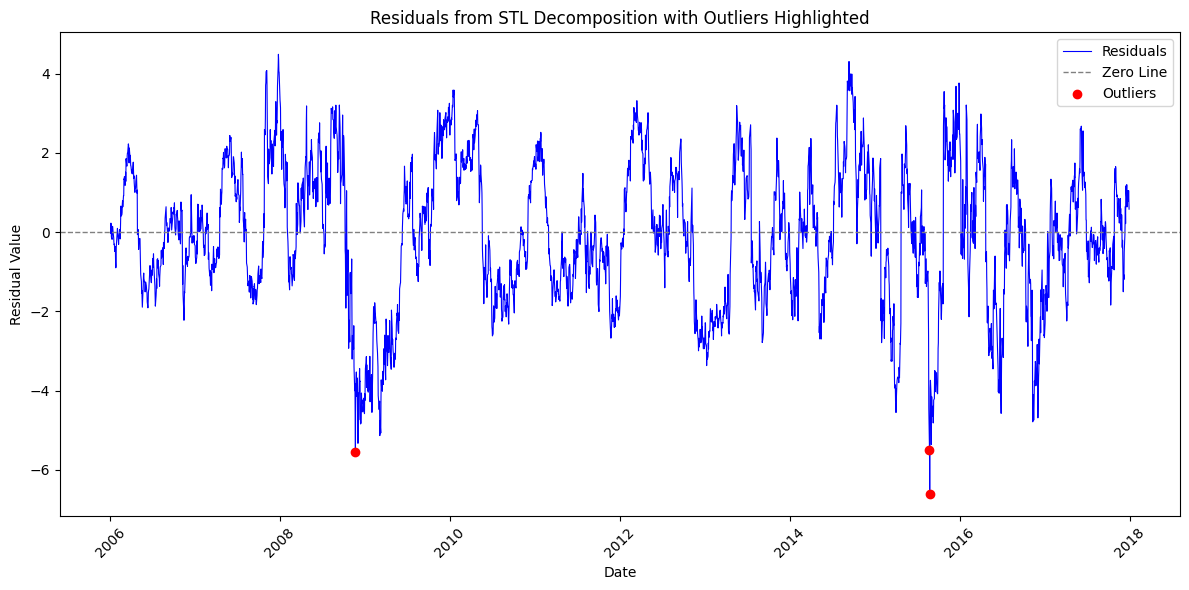

Outliers:
            Date  Close
752  2008-11-20  17.53
2514 2015-08-24  41.68
2515 2015-08-25  40.47


In [45]:
# Define a threshold for outliers (3 standard deviations from the mean)
threshold = np.std(residual) * 3
outliers = residual[np.abs(residual) > threshold]

# Extract dates and residual values for outliers
outlier_dates = data['Date'][np.abs(residual) > threshold]
outlier_residual_values = residual[np.abs(residual) > threshold]

# Plotting residuals with outliers highlighted
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], residual, label='Residuals', color='blue', linewidth=0.8)
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1, label='Zero Line')
plt.title('Residuals from STL Decomposition with Outliers Highlighted')
plt.xlabel('Date')
plt.ylabel('Residual Value')

# Highlight outliers
plt.scatter(outlier_dates, outlier_residual_values, color='red', label='Outliers', zorder=5)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

outlier_closing_values = data.loc[data['Date'].isin(outlier_dates), 'Close']

# Print outlier information
outlier_info = pd.DataFrame({'Date': outlier_dates, 'Close': outlier_closing_values})
print("Outliers:\n", outlier_info)

# Baseline model: Autoregressive

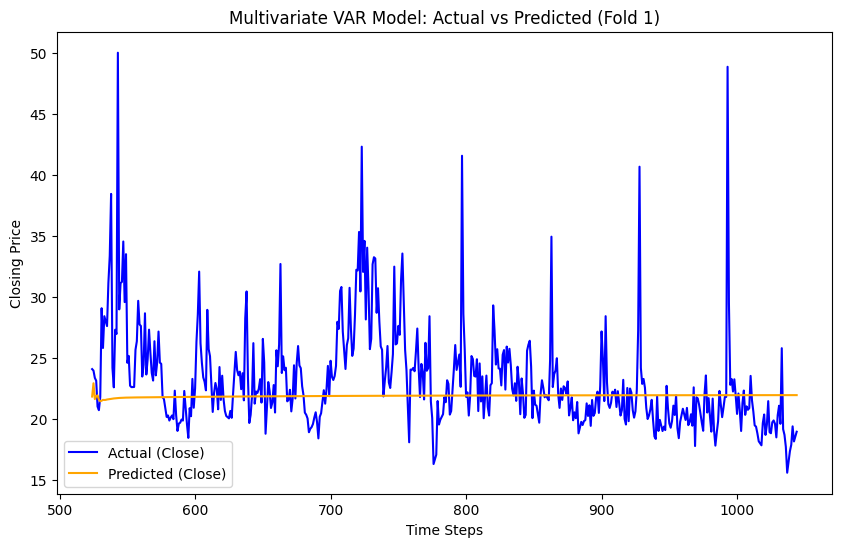

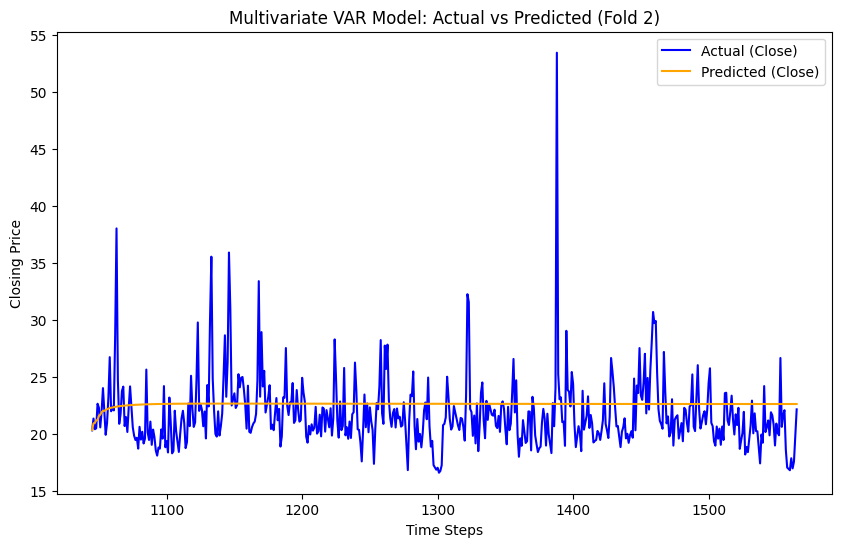

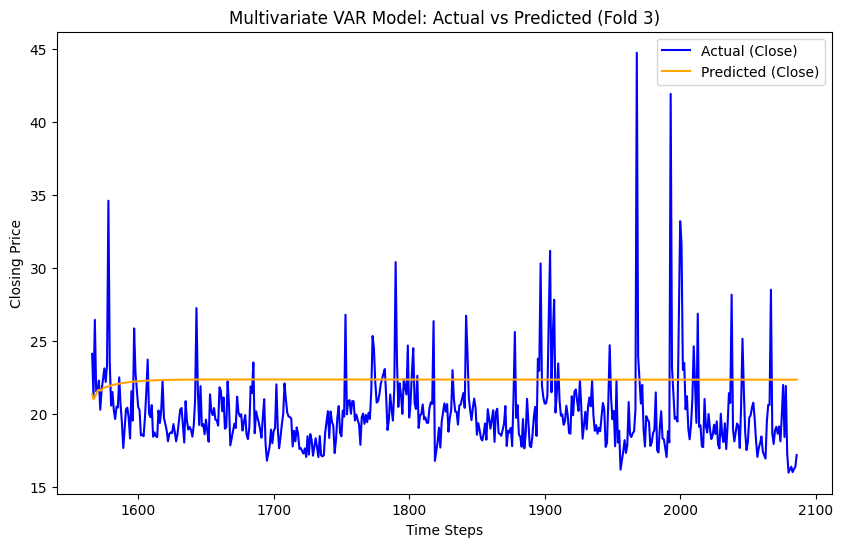

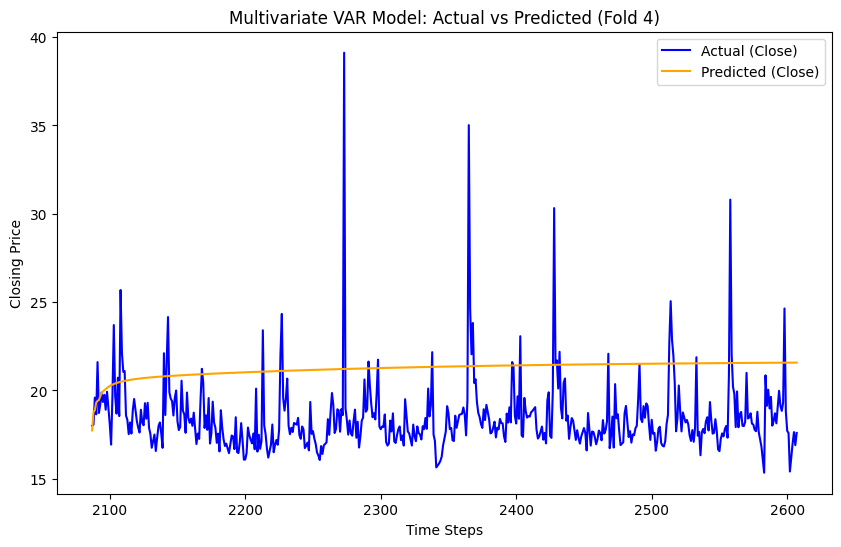

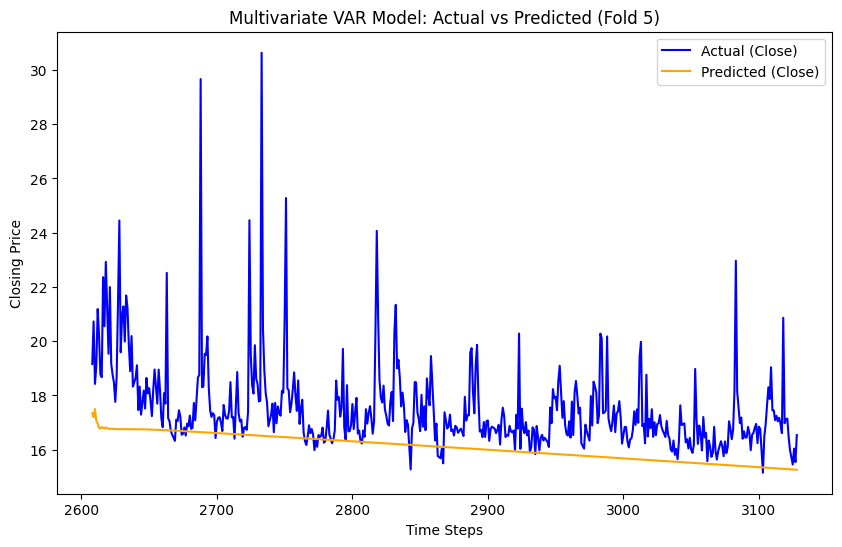

   Fold        MSE      RMSE       MAPE        R2
0     1  18.801845  4.336109  11.146295 -0.106275
1     2  10.289048  3.207655  10.596162 -0.076822
2     3  12.603547  3.550147  15.072120 -0.640022
3     4  12.135471  3.483600  17.425732 -1.879648
4     5   4.214829  2.053005   7.646446 -0.623580


In [46]:
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Separate features and target
features = data.drop(columns=['Close']).values
target = data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

normalized_features = scaler_features.fit_transform(features[:, 1:])
normalized_target = scaler_target.fit_transform(target)

# Combine normalized features and target into one DataFrame
normalized_data = np.hstack([normalized_features, normalized_target])
df = pd.DataFrame(normalized_data, columns=[*data.columns[1:]], index=data.index)

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Store metrics for each fold
metrics = []

for fold, (train_index, test_index) in enumerate(tscv.split(df), 1):
    train, test = df.iloc[train_index], df.iloc[test_index]

    # Fit the VAR (Vector AutoRegression) model
    model = VAR(train)
    model_fitted = model.fit(ic='aic')

    # Forecasting
    pred = model_fitted.forecast(y=train.values[-10:], steps=len(test))

    # Extract the predicted values for 'Close'
    predictions = pred[:, df.columns.get_loc('Close')]

    # Inverse transform the predicted and actual 'Close' values
    test_actual = scaler_target.inverse_transform(test['Close'].values.reshape(-1, 1))
    predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))

    # Calculate metrics
    mse = mean_squared_error(test_actual, predictions)
    mape = mean_absolute_percentage_error(test_actual, predictions) * 100
    rmse = np.sqrt(mse)
    r2 = r2_score(test_actual, predictions)

    # Store metrics for this fold
    metrics.append({
        'Fold': fold,
        'MSE': mse,
        'RMSE': rmse,
        'MAPE': mape,
        'R2': r2
    })

    # Plot the results for this fold
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test_actual, label='Actual (Close)', color='blue')
    plt.plot(test.index, predictions, label='Predicted (Close)', color='orange')
    plt.xlabel('Time Steps')
    plt.ylabel('Closing Price')
    plt.title(f'Multivariate VAR Model: Actual vs Predicted (Fold {fold})')
    plt.legend()
    plt.show()

# Display metrics for each fold
import pandas as pd
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

# Data Spitting and Normalization

In [47]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
features = data.drop(columns=['Date']).values  # All features except 'Date'. I included Close because I think we need to
target = data['Close'].values.reshape(-1, 1)  # Target column

# Min-Max Scaling
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

# Fit and transform
features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

# Sequentially split the dataset into training, validation, and testing sets
train_size = int(len(features_scaled) * 0.6)
val_size = int(len(features_scaled) * 0.2)

train_features = features_scaled[:train_size]
train_target = target_scaled[:train_size]

val_features = features_scaled[train_size:train_size + val_size]
val_target = target_scaled[train_size:train_size + val_size]

test_features = features_scaled[train_size + val_size:]
test_target = target_scaled[train_size + val_size:]

# Define your sequence creation function
def create_sequences(features, target, time_steps=10):
    X, y = [], []
    for i in range(len(features) - time_steps):
        X.append(features[i:i+time_steps])  # Sequence of features
        y.append(target[i+time_steps])  # Target corresponding to the end of the sequence
    return np.array(X), np.array(y)

# Define the number of time steps
time_steps = 10

# Generate sequences for each split
trainX, trainY = create_sequences(train_features, train_target, time_steps)
valX, valY = create_sequences(val_features, val_target, time_steps)
testX, testY = create_sequences(test_features, test_target, time_steps)

# Print shapes of generated sequences
print(f"TrainX shape: {trainX.shape}, TrainY shape: {trainY.shape}")
print(f"ValX shape: {valX.shape}, ValY shape: {valY.shape}")
print(f"TestX shape: {testX.shape}, TestY shape: {testY.shape}")

TrainX shape: (1867, 10, 5), TrainY shape: (1867, 1)
ValX shape: (615, 10, 5), ValY shape: (615, 1)
TestX shape: (617, 10, 5), TestY shape: (617, 1)


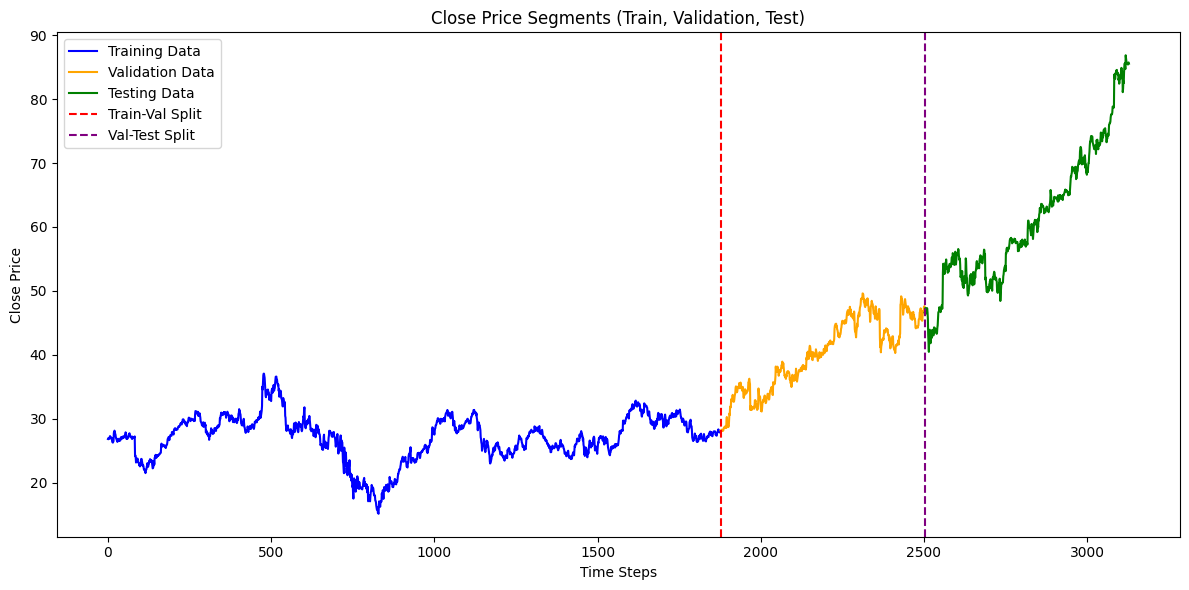

In [48]:
import matplotlib.pyplot as plt

# Prepare the `Close` data for plotting (inverse scale to original range)
close_scaled = np.concatenate([train_target, val_target, test_target]).flatten()
close_original = scaler_target.inverse_transform(close_scaled.reshape(-1, 1)).flatten()

# Calculate indices for splitting
train_end = len(train_target)
val_end = train_end + len(val_target)

# Create x-values for the plot
time_indices = range(len(close_original))

# Plot the data
plt.figure(figsize=(12, 6))
plt.plot(time_indices[:train_end], close_original[:train_end], label='Training Data', color='blue')
plt.plot(time_indices[train_end:val_end], close_original[train_end:val_end], label='Validation Data', color='orange')
plt.plot(time_indices[val_end:], close_original[val_end:], label='Testing Data', color='green')

# Add vertical lines to indicate splits
plt.axvline(x=train_end, color='red', linestyle='--', label='Train-Val Split')
plt.axvline(x=val_end, color='purple', linestyle='--', label='Val-Test Split')

# Add labels, legend, and title
plt.title('Close Price Segments (Train, Validation, Test)')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()


# Stacked RNN model


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0964 - val_loss: 0.0084
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120 - val_loss: 0.0076
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0071 - val_loss: 0.0032
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0051 - val_loss: 0.0025
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0032 - val_loss: 9.6302e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0011
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0021 - val_loss: 4.6249e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0019 - val_loss: 2.2270e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0017 - val_loss: 2.4338e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 7.9657e-04
Epoch 12/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0

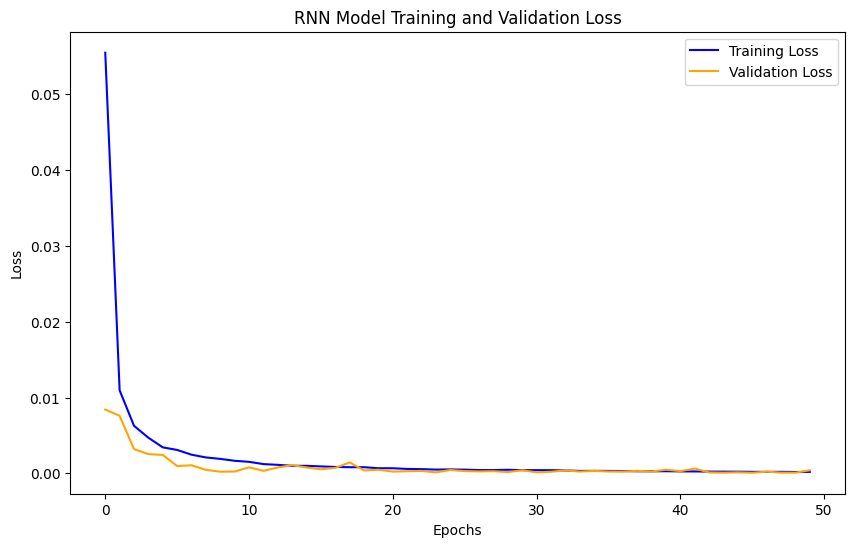

In [49]:
import time
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

# Build the RNN model
RNNmodel = Sequential()
RNNmodel.add(SimpleRNN(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
RNNmodel.add(Dropout(0.2))
RNNmodel.add(SimpleRNN(50))
RNNmodel.add(Dropout(0.2))
RNNmodel.add(Dense(1))

RNNmodel.compile(optimizer='adam', loss='mse')

RNNstart_time = time.time()

# Train the model
history = RNNmodel.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(valX, valY), verbose=1)

RNNtraining_time = time.time() - RNNstart_time
RNNaverage_epoch_time = RNNtraining_time / 50

# Print computational cost
print(f"Total Training Time: {RNNtraining_time:.2f} seconds")
print(f"Average Time per Epoch: {RNNaverage_epoch_time:.2f} seconds")

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('RNN Model Training and Validation Loss')
plt.legend()
plt.show()

In [50]:
# Make predictions for training and testing (validation) data

y_train_pred = RNNmodel.predict(trainX)
y_test_pred = RNNmodel.predict(testX)


trainY_original = scaler_target.inverse_transform(trainY.reshape(-1, 1)).flatten()
testY_original = scaler_target.inverse_transform(testY.reshape(-1, 1)).flatten()

y_train_pred_original = scaler_target.inverse_transform(y_train_pred).flatten()
y_test_pred_original = scaler_target.inverse_transform(y_test_pred).flatten()


# Use scaled values for metrics
trainY_flat = trainY.flatten()
testY_flat = testY.flatten()
y_train_pred_flat = y_train_pred.flatten()
y_test_pred_flat = y_test_pred.flatten()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mape, r2


# Calculate metrics for training data
mse_train, rmse_train, mape_train, r2_train = calculate_metrics(trainY_original, y_train_pred_original)

# Calculate metrics for testing data
mse_test, rmse_test, mape_test, r2_test = calculate_metrics(testY_original, y_test_pred_original)

print("----- Training Metrics -----")
print(f"MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAPE: {mape_train:.2f}%, R²: {r2_train:.4f}")
print("----- Testing Metrics -----")
print(f"MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAPE: {mape_test:.2f}%, R²: {r2_test:.4f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
----- Training Metrics -----
MSE: 0.4025, RMSE: 0.6344, MAPE: 1.82%, R²: 0.9681
----- Testing Metrics -----
MSE: 21.5288, RMSE: 4.6399, MAPE: 6.37%, R²: 0.8127


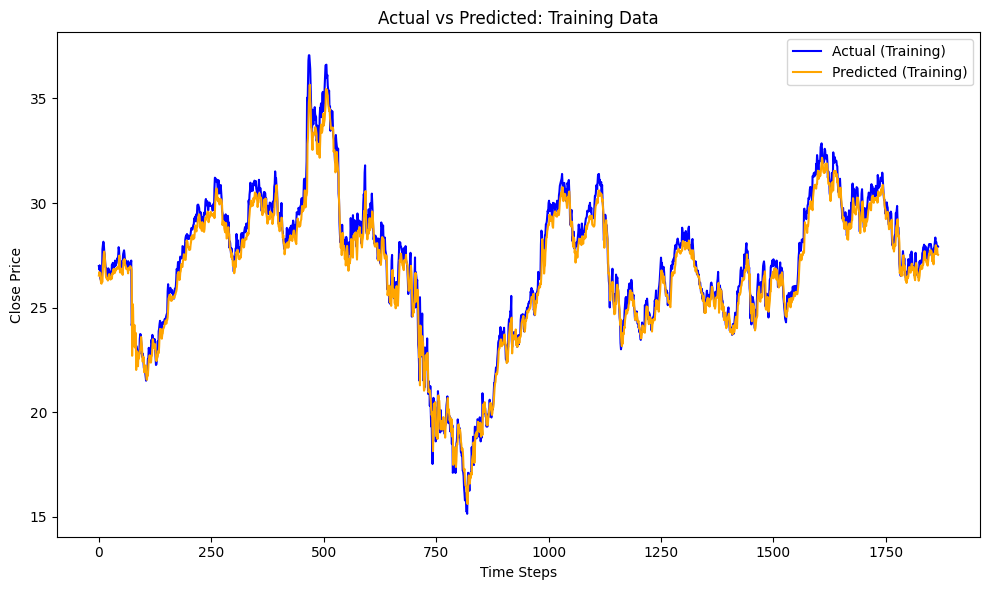

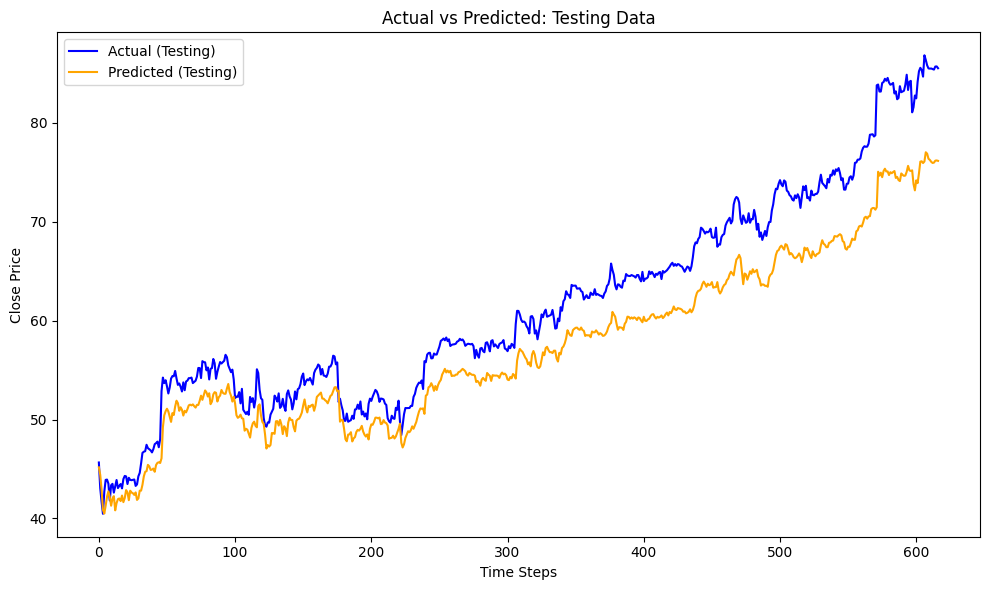

In [51]:
# Plot Actual vs Predicted for Training Data
plt.figure(figsize=(10, 6))
plt.plot(trainY_original, label='Actual (Training)', color='blue')
plt.plot(y_train_pred_original, label='Predicted (Training)', color='orange')
plt.title('Actual vs Predicted: Training Data')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Actual vs Predicted for Testing Data
plt.figure(figsize=(10, 6))
plt.plot(testY_original, label='Actual (Testing)', color='blue')
plt.plot(y_test_pred_original, label='Predicted (Testing)', color='orange')
plt.title('Actual vs Predicted: Testing Data')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()


# LSTM model

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0071 - val_loss: 0.0030
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.9595e-04 - val_loss: 3.4990e-04
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.3455e-04 - val_loss: 2.9328e-04
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.4092e-04 - val_loss: 2.6766e-04
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 4.0597e-04 - val_loss: 2.6450e-04
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 3.9218e-04 - val_loss: 5.6816e-04
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 4.3771e-04 - val_loss: 2.7715e-04
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.7873e-04 - val_loss: 2.7572e-04
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.6643e-04 - val_loss: 2.5732e-04
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 3.0108e-04 - val_loss: 5.1087e-04
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.2657e-04 - val_loss: 2.785

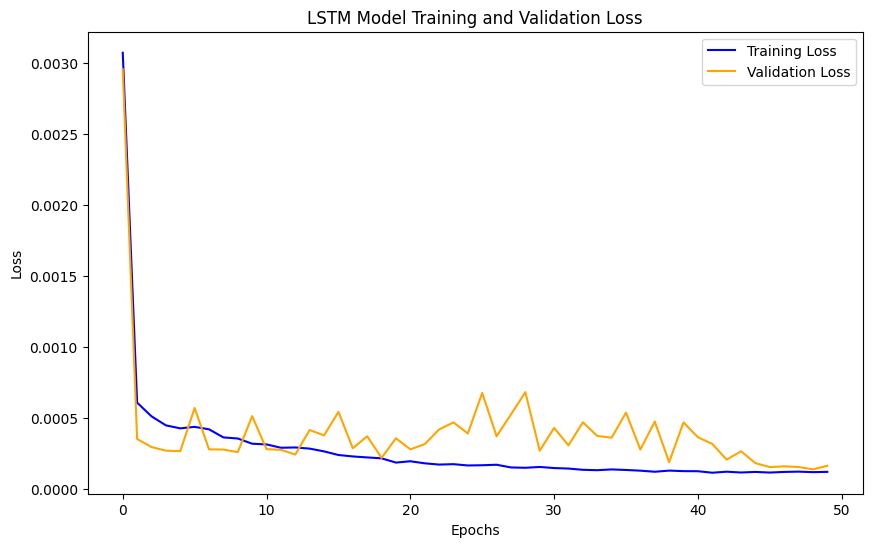

In [52]:
import time
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score


# Build the RNN model
LSTMmodel = Sequential()
LSTMmodel.add(LSTM(50, return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(LSTM(25))
LSTMmodel.add(Dropout(0.2))
LSTMmodel.add(Dense(1))

LSTMmodel.compile(optimizer='adam', loss='mse')

LSTMstart_time = time.time()

# Train the model
history = LSTMmodel.fit(trainX, trainY, epochs=50, batch_size=32, validation_data=(valX, valY), verbose=1)

LSTMtraining_time = time.time() - LSTMstart_time
LSTMaverage_epoch_time = LSTMtraining_time / 50

# Print computational cost
print(f"Total Training Time: {LSTMtraining_time:.2f} seconds")
print(f"Average Time per Epoch: {LSTMaverage_epoch_time:.2f} seconds")


# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('LSTM Model Training and Validation Loss')
plt.legend()
plt.show()

In [53]:
# Make predictions for training and testing (validation) data

y_train_pred = LSTMmodel.predict(trainX)
y_test_pred = LSTMmodel.predict(testX)


trainY_original = scaler_target.inverse_transform(trainY.reshape(-1, 1)).flatten()
testY_original = scaler_target.inverse_transform(testY.reshape(-1, 1)).flatten()

y_train_pred_original = scaler_target.inverse_transform(y_train_pred).flatten()
y_test_pred_original = scaler_target.inverse_transform(y_test_pred).flatten()


# Use scaled values for metrics
trainY_flat = trainY.flatten()
testY_flat = testY.flatten()
y_train_pred_flat = y_train_pred.flatten()
y_test_pred_flat = y_test_pred.flatten()

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mape, r2


# Calculate metrics for training data
mse_train, rmse_train, mape_train, r2_train = calculate_metrics(trainY_original, y_train_pred_original)

# Calculate metrics for testing data
mse_test, rmse_test, mape_test, r2_test = calculate_metrics(testY_original, y_test_pred_original)

print("----- Training Metrics -----")
print(f"MSE: {mse_train:.4f}, RMSE: {rmse_train:.4f}, MAPE: {mape_train:.2f}%, R²: {r2_train:.4f}")
print("----- Testing Metrics -----")
print(f"MSE: {mse_test:.4f}, RMSE: {rmse_test:.4f}, MAPE: {mape_test:.2f}%, R²: {r2_test:.4f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
----- Training Metrics -----
MSE: 0.4931, RMSE: 0.7022, MAPE: 2.11%, R²: 0.9610
----- Testing Metrics -----
MSE: 7.1915, RMSE: 2.6817, MAPE: 3.52%, R²: 0.9374


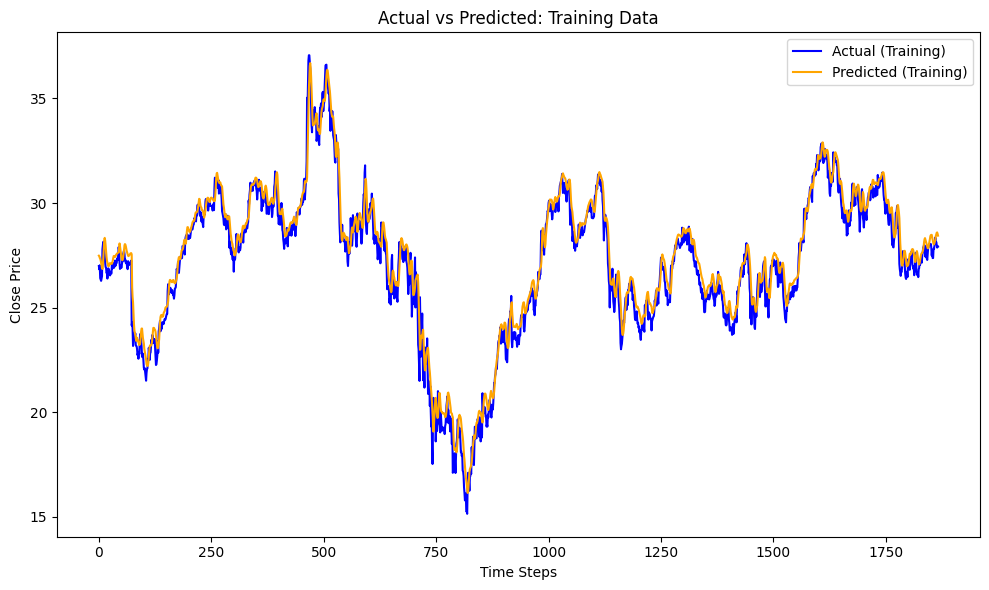

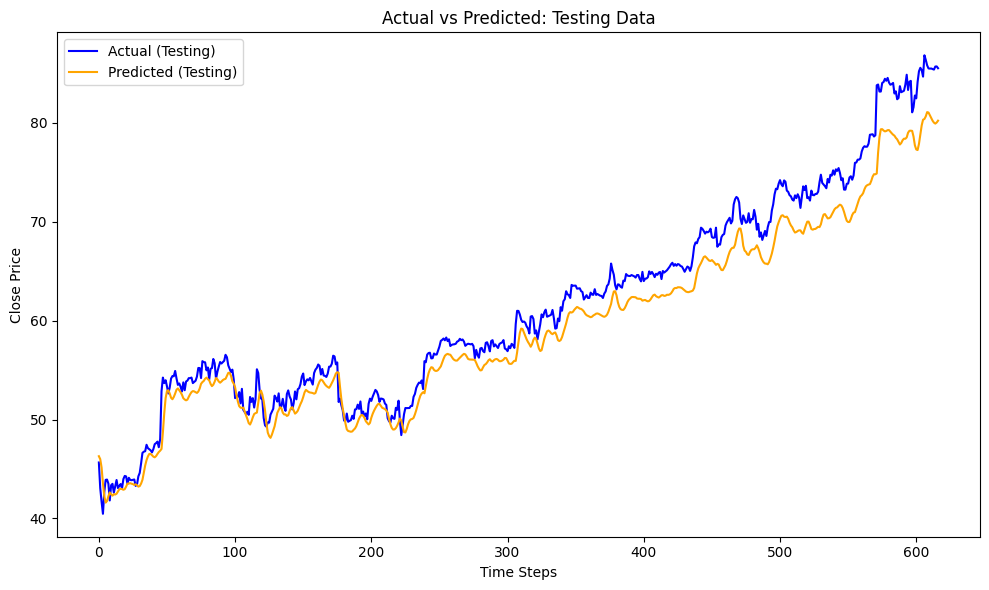

In [54]:
# Plot Actual vs Predicted for Training Data
plt.figure(figsize=(10, 6))
plt.plot(trainY_original, label='Actual (Training)', color='blue')
plt.plot(y_train_pred_original, label='Predicted (Training)', color='orange')
plt.title('Actual vs Predicted: Training Data')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()

# Plot Actual vs Predicted for Testing Data
plt.figure(figsize=(10, 6))
plt.plot(testY_original, label='Actual (Testing)', color='blue')
plt.plot(y_test_pred_original, label='Predicted (Testing)', color='orange')
plt.title('Actual vs Predicted: Testing Data')
plt.xlabel('Time Steps')
plt.ylabel('Close Price')
plt.legend()
plt.tight_layout()
plt.show()